In [56]:
import pyccl as ccl
import pyccl.nl_pt as pt                                                        

In [400]:
ccl.spline_params.ELL_MAX_CORR = 500_000
ccl.spline_params.N_ELL_CORR = 5_000

In [401]:
import numpy as np
import matplotlib.pylab

In [380]:
# Linear galaxy bias
bias_1 = 1.1

In [402]:
# Define two cases of minimum redshift for lens distribution

z_min = {'a':  0.06, 'b' : 0.07}

# Plotting styles
linestyle = {'a': ':', 'b': '--'}

# Lens redshift distribution
z_lens = {}
dndz_lens = {}

for key in z_min:
    z_lens[key] = np.arange(z_min[key], 0.5, 0.01)
    dndz_lens[key] = np.ones_like(z_lens[key])

In [403]:
# Source redshift distribution
z_source = np.arange(0.2, 1.5, 0.1)
z_0 = 0.5
beta = 1.5

dndz_source = (z_source / z_0)**2 * np.exp(- (z_source / z_0) ** beta)

In [404]:
#from unions_wl import catalogue as cat
#z_lens, dndz_lens, x = cat.read_dndz('/home/mkilbing/astro/Runs/UNIONS/ggl-agn/jobs/Shen22_and_Liu19_logM_min_7_nz_0_z_0.1_0.8/hist_z_0_n_split_1_w.txt')
#z_source, dndz_source, x = cat.read_dndz('/home/mkilbing/astro/data/CFIS/v1.0/nz/dndz_SP_A.txt')

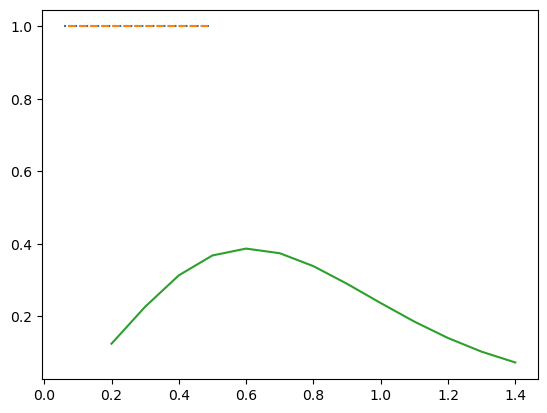

In [405]:
for key in z_min:
    plt.plot(z_lens[key], dndz_lens[key], linestyle=linestyle[key])
_ = plt.plot(z_source, dndz_source)

In [406]:
# Set cosmology and galaxy bias(z)
cosmo = ccl.Cosmology(                                                  
        Omega_c=0.27,                                                           
        Omega_b=0.045,                                                          
        h=0.67,                                                                 
        sigma8=0.83,                                                            
        n_s=0.96,                                                               
)

bias_g = {}

for key in z_min:
    bias_g[key] = np.ones_like(z_lens[key]) * bias_1

In [407]:
# Compute tracers for lenses and sources
tracer_g = {}

for key in z_min:
    tracer_g[key] = ccl.NumberCountsTracer(                                          
    cosmo,                                                              
    False,                                                              
    dndz=(z_lens[key], dndz_lens[key]),                                                     
    bias=(z_lens[key], bias_g[key]),                                  
)

tracer_l = ccl.WeakLensingTracer(                                           
    cosmo,                                                        
    dndz=(z_source, dndz_source),                                              
    n_samples=len(dndz_source),                                           
)

In [408]:
# Pre-compute 3D matter power spectrum
log10k_min = -4
log10k_max = 2
nk_per_decade = 20

ptt_g = pt.PTNumberCountsTracer(b1=bias_1)                                  
                                                                                
# Dark matter                                                               
ptt_m = pt.PTMatterTracer()                                                 
                                                                                
# Power spectrum                                        
ptc = pt.PTCalculator(                                                      
    with_NC=True,                                                           
    with_IA=False,                                                          
    log10k_min=log10k_min,                                                  
    log10k_max=log10k_max,                                                  
    nk_per_decade=nk_per_decade,                                            
)                                                                           
                                                                                
# 3D galaxy - dark-matter cross power spectrum                              
pk_gm = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_m, ptc=ptc)

In [409]:
# Angular power spectrum
ell_min = 2
ell_max = 50_000
ell = np.arange(ell_min, ell_max)

cls_gG = {}

for key in z_min:
    cls_gG[key] = ccl.angular_cl(                                                    
        cosmo,                                                                  
        tracer_g[key],                                                               
        tracer_l,                                                     
        ell,
        p_of_k_a=pk_gm,
        limber_integration_method='qag_quad',
    )

In [410]:
# Tangential shear

# Angular scales in arc minutes
th_min_amin = 0.15
th_max_amin = 150
n_th = 1000

theta_amin = np.logspace(np.log10(th_min_amin), np.log10(th_max_amin), num=n_th)
theta_deg = theta_amin / 60

gt = {}

for key in z_min:
    gt[key] = ccl.correlation(                                                       
        cosmo,                                                                  
        ell,                                                                    
        cls_gG[key],                                                                 
        theta_deg,                                                              
        type='NG',                                                              
        method='FFTlog',          
    )          

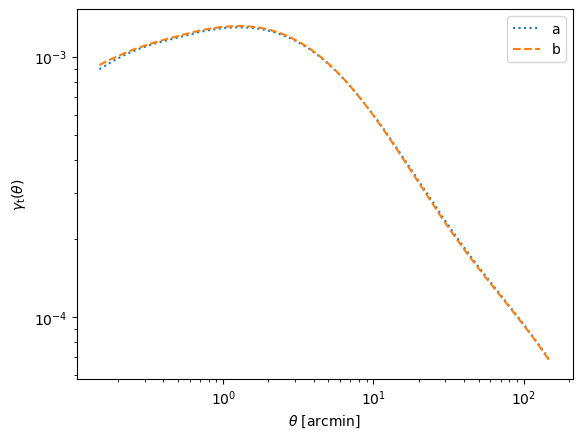

In [411]:
for key in z_min:
    plt.loglog(theta_amin, gt[key], linestyle=linestyle[key], label=key)
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
_ = plt.ylabel(r'$\gamma_{\rm t}(\theta)$')